In [695]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [629]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-07.csv'

print(today_date_str)

_2024-03-13.csv


In [630]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1136 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3085711467608.9995,USD,415.28,USD,415.99,USD,3.08,USD,0.741668,0.170969,7318827360.76,22456969,38577755,122683,20511079.5,22851085.63333334,24654685.33333333,2.716389,2.238736,1.523403,412.546667,37.55912705,Technology Services,0.70794701,1.0122284,1.0291758,0.8906199,4.439959,3.915402,2.771495,1.912760,1.018511,0.590615,0.789381,1.1371213,0.35259876,0.30117471,420.740,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,415.57,USD,415.570,USD,415.5700,USD,415.5700,USD,415.5700,USD,415.57,USD,415.570,USD,415.570,USD,417.350,USD,958891.40271493,USD,415.32400,415.286875,414.99300,415.006669,415.512203,415.097600,414.682997,415.462477,414.994585,414.526693
1,AMZN,"Amazon.com, Inc.",NASDAQ,1821842722586,USD,175.39,USD,175.38,USD,0.83,USD,0.473231,-0.005702,9234336275.6,36610494,65095381,179166,35771898.60000006,47212759.06666667,47027001.66666668,2.791022,2.545484,1.911044,174.710000,60.69698228,Retail Trade,0.68342432,1.1478652,1.3817025,1.1703976,4.010038,4.893946,3.845179,1.759921,0.880668,0.454421,0.550196,1.03933203,0.2945744,0.24508298,180.140,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,175.76,USD,175.940,USD,175.9400,USD,175.9400,USD,175.9400,USD,176.05,USD,176.760,USD,176.760,USD,180.140,USD,376908.19672131,USD,175.56394,175.629350,175.69200,175.723815,176.036629,175.756130,175.475631,175.971299,175.715230,175.459161
2,GOOG,Alphabet Inc.,NASDAQ,1728321992309.9998,USD,139.62,USD,139.60,USD,0.20,USD,0.143246,-0.014325,5274001645,19019696,41556061,77185,28201691.79999998,25388559.93333337,22308989.75555557,1.497721,2.499190,1.955769,139.370000,24.05085096,Technology Services,0.398516,1.0631686,1.1586931,1.0489115,3.802944,5.537850,4.033052,2.541021,1.012352,0.507881,0.575384,0.66651303,0.38534749,0.44723422,150.590,USD,155.20,USD,155.20,USD,155.20,USD,155.20000,USD,139.82,USD,139.965,USD,140.0500,USD,140.0500,USD,140.0500,USD,140.17,USD,140.280,USD,140.280,USD,140.280,USD,1683033.61059057,USD,139.67700,139.732250,139.83910,139.885900,140.112586,139.855375,139.598164,140.140917,139.910320,139.679723
3,GOOGL,Alphabet Inc.,NASDAQ,1728321992309.9998,USD,138.50,USD,138.48,USD,0.18,USD,0.129964,-0.0

In [631]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [632]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.085711e+12,USD,415.28,USD,415.99,USD,3.08,USD,0.741668,0.170969,7318827360.76,22456969,38577755,122683,20511079.5,22851085.63333334,24654685.33333333,2.716389,2.238736,1.523403,412.546667,37.55912705,Technology Services,0.70794701,1.0122284,1.0291758,0.8906199,4.439959,3.915402,2.771495,1.912760,1.018511,0.590615,0.789381,1.1371213,0.35259876,0.30117471,420.740,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,415.57,USD,415.570,USD,415.5700,USD,415.5700,USD,415.5700,USD,415.57,USD,415.570,USD,415.570,USD,417.350,USD,958891.40271493,USD,415.32400,415.286875,414.99300,415.006669,415.512203,415.097600,414.682997,415.462477,414.994585,414.526693,Titans
1,AMZN,"Amazon.com, Inc.",NASDAQ,1.821843e+12,USD,175.39,USD,175.38,USD,0.83,USD,0.473231,-0.005702,9234336275.6,36610494,65095381,179166,35771898.60000006,47212759.06666667,47027001.66666668,2.791022,2.545484,1.911044,174.710000,60.69698228,Retail Trade,0.68342432,1.1478652,1.3817025,1.1703976,4.010038,4.893946,3.845179,1.759921,0.880668,0.454421,0.550196,1.03933203,0.2945744,0.24508298,180.140,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,175.76,USD,175.940,USD,175.9400,USD,175.9400,USD,175.9400,USD,176.05,USD,176.760,USD,176.760,USD,180.140,USD,376908.19672131,USD,175.56394,175.629350,175.69200,175.723815,176.036629,175.756130,175.475631,175.971299,175.715230,175.459161,Titans
2,GOOG,Alphabet Inc.,NASDAQ,1.728322e+12,USD,139.62,USD,139.60,USD,0.20,USD,0.143246,-0.014325,5274001645,19019696,41556061,77185,28201691.79999998,25388559.93333337,22308989.75555557,1.497721,2.499190,1.955769,139.370000,24.05085096,Technology Services,0.398516,1.0631686,1.1586931,1.0489115,3.802944,5.537850,4.033052,2.541021,1.012352,0.507881,0.575384,0.66651303,0.38534749,0.44723422,150.590,USD,155.20,USD,155.20,USD,155.20,USD,155.20000,USD,139.82,USD,139.965,USD,140.0500,USD,140.0500,USD,140.0500,USD,140.17,USD,140.280,USD,140.280,USD,140.280,USD,1683033.61059057,USD,139.67700,139.732250,139.83910,139.885900,140.112586,139.855375,139.598164,140.140917,139.910320,139.679723,Titans
3,GOOGL,Alphabet Inc.,NASDAQ,1.728322e+12,USD,138.50,USD,138.48,USD,0.18,U

In [633]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [634]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1136 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,277,24.383803
1,Shrimp,232,20.422535
2,Midlers,209,18.397887
3,Micro caps,197,17.341549
4,Large caps,191,16.813380
5,Titans,22,1.936620
6,Undefined,8,0.704225


In [635]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1128 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
153,BAX,Baxter International Inc.,NYSE,2.178072e+10,USD,42.89,USD,43.15,USD,0.2600,USD,0.606202,0.606202,504876017.303,3648644,5621878,125,4001049.3,3977072.1,4017794.33333337,1.541336,2.322246,2.356482,43.026667,-,Health Technology,0.3485632,1.017807,0.74084616,0.62067616,8.623193,7.601685,8.129433,5.692448,2.354738,1.131486,0.737738,0.94771414,0.30488416,0.33220775,44.005,USD,44.0050,USD,44.005,USD,50.2100,USD,95.1900,USD,42.960,USD,42.960,USD,43.065,USD,43.065,USD,43.065,USD,43.120,USD,43.3700,USD,43.970,USD,44.005,USD,246883.33333333,USD,42.9280,42.930625,42.9412,42.993538,42.985426,42.931550,42.877674,43.141154,43.020050,42.898946,Large caps
362,RIOT,"Riot Platforms, Inc.",NASDAQ,2.946114e+09,USD,11.62,USD,12.03,USD,0.0001,USD,0.000861,3.528399,227863727.968,20965115,47557539,334666,31920736.5,27207520.9,29399162.34444445,5.444887,9.956639,10.307233,11.608333,-,Technology Services,0.3800258,2.7746203,3.518151,4.2813225,2.744218,3.174821,2.529943,1.527054,0.674150,0.331119,0.464770,0.61326282,0.34969679,0.42680215,18.360,USD,18.7500,USD,18.750,USD,20.6500,USD,3638.4000,USD,11.640,USD,11.670,USD,11.680,USD,11.680,USD,11.680,USD,11.730,USD,11.9100,USD,12.900,USD,14.990,USD,525614.23220974,USD,11.6285,11.634063,11.6354,11.652000,11.670380,11.643095,11.615810,11.712131,11.649420,11.586709,Midlers
690,RGTI,"Rigetti Computing, Inc.",NASDAQ,3.240888e+08,USD,2.21,USD,2.23,USD,0.0098,USD,0.443439,0.904977,99609388.162,15306048,23546033,582547,10872871.5,9413019.2,4719502.13333333,19.354839,18.566314,16.708741,2.096667,-,Electronic Technology,0.96850209,1.8805494,2.5041084,2.5041084,1.626591,2.401960,2.758564,1.298690,0.862170,0.531816,0.703705,1.52463814,0.77820968,0.78116221,2.360,USD,2.3600,USD,2.360,USD,3.4300,USD,12.7500,USD,2.210,USD,2.220,USD,2.220,USD,2.220,USD,2.220,USD,2.220,USD,2.2200,USD,2.220,USD,2.360,USD,90986.11111111,USD,2.2070,2.208125,2.1960,2.173854,2.223795,2.196250,2.168705,2.211460,2.165255,2.119050,Small caps
220,APA,APA Corporation,NASDAQ,9.480840e+09,USD,31.44,USD,31.50,USD,0.3700,USD,1.176845,0.190840,299915567.21,4968992,9444618,5321,5462263.4,6138757.7,5148254.34444444,1.893204,2.377823,2.684336,31

In [636]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [637]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [638]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1128
Number of rows removed: 1124
NEW DataFrame length: 4


In [639]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Midlers,3,75.0
1,Small caps,1,25.0


In [640]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'Relative Volume 1 month

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,PPC,Pilgrim's Pride Corporation,NASDAQ,7.904077e+09,USD,33.38,USD,33.50,USD,0.12,USD,0.359497,0.359497,4.090967e+07,1379236,2332077,270,926686.2,799847.23333333,703561.65555556,2.656489,2.289256,2.340457,33.250000,24.64014173,Process Industries,1.075145,0.68148583,0.6066818,0.81960094,4.991516,3.740428,4.172256,4.356717,2.104161,1.711917,2.026118,1.396645,0.70510603,0.39453076,33.62,USD,33.62,USD,33.62,USD,33.62,USD,38.6400,USD,33.49,USD,33.490,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,283649.80392157,USD,33.4260,33.441450,33.44800,33.465769,33.502778,33.432830,33.362882,33.590250,33.432500,33.274750,Midlers
1,ITRI,"Itron, Inc.",NASDAQ,4.171497e+09,USD,91.52,USD,91.75,USD,0.23,USD,0.251311,0.251311,4.506268e+07,852780,1394358,271,559071,469752.56666667,380865.37777778,3.251308,3.077919,3.217879,91.353333,43.38263178,Electronic Technology,0.763768,1.5433061,1.5750945,1.4103701,0.966749,4.952543,6.864931,2.680826,1.306107,0.950493,1.037304,1.413700,0.75969225,0.51849807,96.73,USD,96.73,USD,96.73,USD,96.73,USD,122.3100,USD,91.60,USD,92.015,USD,92.06,USD,92.06,USD,92.06,USD,92.48,USD,92.73,USD,95.75,USD,96.73,USD,370990.44205496,USD,91.3850,91.412500,91.73100,91.957500,92.105709,91.640500,91.175291,92.463986,91.969375,91.474764,Midlers
2,PAY,"Paymentus Holdings, Inc.",NYSE,2.965466e+09,USD,23.93,USD,24.40,USD,0.47,USD,1.964062,1.964062,1.649416e+07,1438710,2299186,6800,795070.2,340992.73333333,214308.18888889,16.166505,11.103245,5.164183,22.863333,134.58942632,Commercial Services,1.439815,1.4165473,1.4026895,1.4026895,2.606430,4.427288,2.549021,1.378952,0.965617,0.688696,1.208089,2.141640,2.29537636,3.4249406,24.00,USD,24.00,USD,24.00,USD,24.00,USD,39.2292,USD,24.00,USD,24.000,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,482710.13354281,USD,23.8929,23.889937,23.82918,23.656992,23.960174,23.848005,23.735836,23.997043,23.524260,23.051477,Midlers
3,GRND,Grindr Inc.,NYSE,1.750586e+09,USD,10.00,USD,10.10,USD,0.10,USD,1.000000,1.000000,1.353830e+07,2195762,2851262,1498,862698.9,458074.23333333,516130.5,9.880565,7.084122,4.334760,9.776667,-,Technology Services,1.983094,

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [641]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [642]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [643]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [644]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 4/4 [00:00<00:00, 1022.25it/s]


In [645]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-16
END date: 2024-03-13
103 days of historical stock data.

412 = Length of dataframe
4 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['PPC', 'ITRI', 'PAY', 'GRND']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
402,8.28,8.480,8.20,8.38,2024-02-29,GRND,436985,HISTORICAL_PRICES,GRND,,2024-02-29,1709258455000,0.427586,0.427586,8.38,8.28,8.480,8.20,436985,8.38,8.28,8.480,8.20,436985,"Feb 29, 24",0.01,0.0012,GRND
403,8.09,8.380,8.01,8.30,2024-03-01,GRND,463346,HISTORICAL_PRICES,GRND,,2024-03-01,1709350260000,0.394828,0.394828,8.30,8.09,8.380,8.01,463346,8.30,8.09,8.380,8.01,463346,"Mar 1, 24",-0.19,-0.0229,GRND
404,8.33,8.350,7.93,8.11,2024-03-04,GRND,589845,HISTORICAL_PRICES,GRND,,2024-03-04,1709604075000,0.436207,0.436207,8.11,8.33,8.350,7.93,589845,8.11,8.33,8.350,7.93,589845,"Mar 4, 24",0.24,0.0297,GRND
405,8.16,8.500,8.10,8.34,2024-03-05,GRND,762380,HISTORICAL_PRICES,GRND,,2024-03-05,1709692223000,0.406897,0.406897,8.34,8.16,8.500,8.10,762380,8.34,8.16,8.500,8.10,762380,"Mar 5, 24",-0.17,-0.0204,GRND
406,8.25,8.415,7.97,8.25,2024-03-06,GRND,572123,HISTORICAL_PRICES,GRND,,2024-03-06,1709776847000,0.422414,0.422414,8.25,8.25,8.415,7.97,572123,8.25,8.25,8.415,7.97,572123,"Mar 6, 24",0.09,0.0110,GRND
407,8.71,8.780,8.24,8.35,2024-03-07,GRND,1338915,HISTORICAL_PRICES,GRND,,2024-03-07,1709863205000,0.501724,0.501724,8.35,8.71,8.780,8.24,1338915,8.35,8.71,8.780,8.24,1338915,"Mar 7, 24",0.46,0.0558,GRND
408,9.35,9.670,9.05,9.33,2024-03-08,GRND,1352025,HISTORICAL_PRICES,GRND,,2024-03-08,1709951468000,0.612069,0.612069,9.33,9.35,9.670,9.05,1352025,9.33,9.35,9.670,9.05,1352025,"Mar 8, 24",0.64,0.0735,GRND
409,9.48,9.560,9.20,9.23,2024-03-11,GRND,655500,HISTORICAL_PRICES,GRND,,2024-03-11,1710230496000,0.634483,0.634483,9.23,9.48,9.560,9.20,655500,9.23,9.48,9.560,9.20,655500,"Mar 11, 24",0.13,0.0139,GRND
410,10.00,10.120,9.21,9.48,2024-03-12,GRND,2195762,HISTORICAL_PRICES,GRND,,2024-03-12,1710297049000,0.724138,0.724138,9.48,10.00,10.120,9.21,2195762,9.48,10.00,10.120,9.21,2195762,"Mar 12, 24",0.52,0.0549,GRND
411,10.23,10.340,9.92,9.97,2024-03-13,GRND,935789,HISTORICAL_PRICES,GRND,,2024-03-13,1710381667000,0.763793,0.763793,9.97,10.23,10.340,9.92,935789,9.97,10.23,10.340,9.92,935789,"Mar 13, 24",0.23,0.0230,GRND


In [646]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [647]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,GRND,2024-03-13,10.23,10.34,9.920,9.97,935789
1,ITRI,2024-03-13,89.18,92.47,88.655,91.68,521847
2,PAY,2024-03-13,24.87,24.99,23.510,24.20,846878
3,PPC,2024-03-13,32.98,33.69,32.650,33.54,1075804


In [648]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 412


In [649]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [650]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,PPC,2023-10-16,24.27,24.380,23.780,24.06,661824
206,PAY,2023-10-16,15.92,16.090,15.625,16.09,95892
309,GRND,2023-10-16,5.80,5.940,5.790,5.89,281822
103,ITRI,2023-10-16,58.74,58.900,57.760,57.96,265507
1,PPC,2023-10-17,24.47,24.885,24.270,24.35,1136326


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [651]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-16,PPC,24.27,24.380,23.780,24.06,661824
2023-10-16,PAY,15.92,16.090,15.625,16.09,95892
2023-10-16,GRND,5.80,5.940,5.790,5.89,281822
2023-10-16,ITRI,58.74,58.900,57.760,57.96,265507
2023-10-17,PPC,24.47,24.885,24.270,24.35,1136326


| TICKER - Unit TESTING | 
|-|

In [652]:
# filter by symbol
ticker = 'PPC'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-02-29,PPC,31.84,32.500,31.310,32.48,1403307
2024-03-01,PPC,32.09,32.120,31.565,31.83,1015175
2024-03-04,PPC,31.85,32.250,31.600,32.09,685146
2024-03-05,PPC,32.30,32.510,31.800,32.00,738070
2024-03-06,PPC,31.97,32.315,31.730,32.31,502648
2024-03-07,PPC,32.39,32.450,31.770,32.07,858730
2024-03-08,PPC,32.39,32.450,32.060,32.33,435075
2024-03-11,PPC,32.86,33.120,32.420,32.57,952841
2024-03-12,PPC,33.38,33.620,32.750,32.77,1379236


In [653]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-02-29,PPC,31.84,32.500,31.310,32.48,1403307
2024-03-01,PPC,32.09,32.120,31.565,31.83,1015175
2024-03-04,PPC,31.85,32.250,31.600,32.09,685146
2024-03-05,PPC,32.30,32.510,31.800,32.00,738070
2024-03-06,PPC,31.97,32.315,31.730,32.31,502648
2024-03-07,PPC,32.39,32.450,31.770,32.07,858730
2024-03-08,PPC,32.39,32.450,32.060,32.33,435075
2024-03-11,PPC,32.86,33.120,32.420,32.57,952841
2024-03-12,PPC,33.38,33.620,32.750,32.77,1379236


| DATA PACKAGE |
|-|
| Technical Indicators |


In [ ]:
# Step 1: Extract the last 24 closing prices
trend_line24_df = ticker_df[['Close']].tail(24)
trend_line24_df['Index'] = np.arange(len(ticker_df) - 24, len(ticker_df))

# # Step 2: Perform a linear regression
# X = trend_line24_df['Index'].values.reshape(-1, 1)  # Reshape for scikit-learn
# y = trend_line24_df['Close'].values
# model = LinearRegression().fit(X, y)

# # Step 3: Calculate the y-values for the line of best fit
# ticker_df['Index'] = np.arange(len(ticker_df))
# ticker_df['BestFit'] = model.predict(ticker_df[['Index']].values.reshape(-1, 1))

# # Step 4: Plot the original candlestick chart
# apd = mpf.make_addplot(ticker_df['BestFit'])
# mpf.plot(ticker_df, 
#          type='candle', 
#          style='charles', 
#          volume=True, 
#          title=f'{ticker} Candlestick Chart with Volume',
#          figratio=(42, 14),
#          addplot=apd)

# mpf.show()


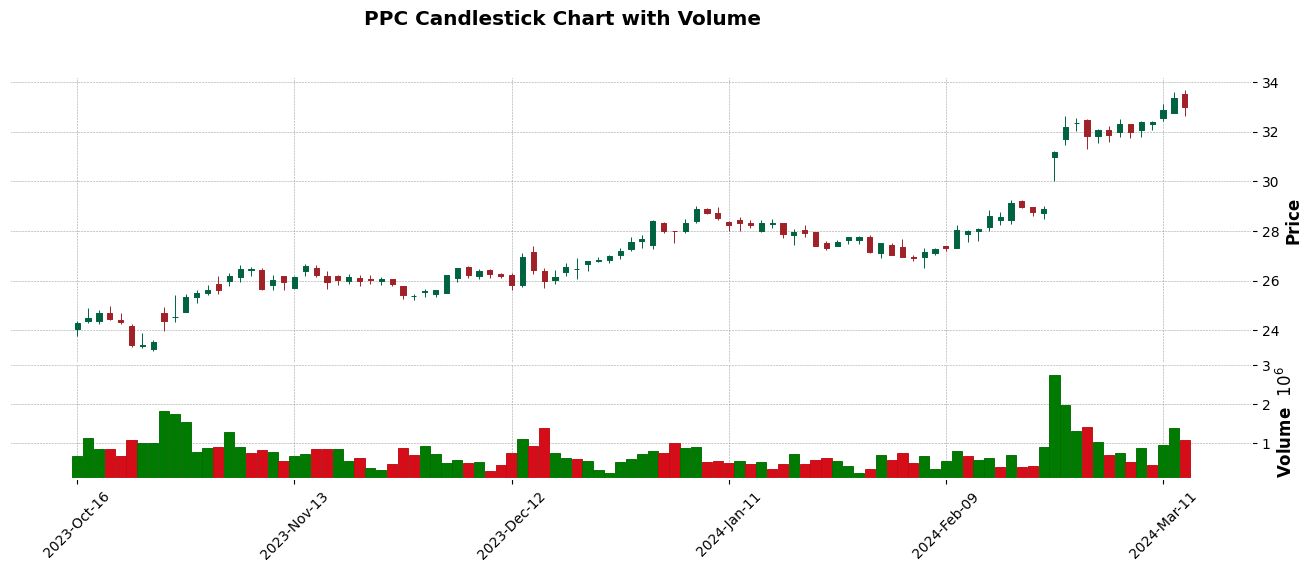

In [654]:
#### mplfinance - CHARTING ####
mpf.plot(ticker_df, 
                        type='candle', 
                        style='charles', 
                        volume=True, 
                        title=f'{ticker} Candlestick Chart with Volume', 
                        figratio=(42, 14))

mpf.show()

| Dataframe -> .csv file |
|-|

In [655]:
# create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
ticker_csv_df = ticker_df.reset_index()
# dtype of date
print(ticker_csv_df['date'].dtype)
# print index type
print(ticker_csv_df.index.dtype)

# save to csv
ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

ticker_csv_df.head(2)


datetime64[ns]
int64


,date,symbol,Close,High,Low,Open,Volume
0,2023-10-16,PPC,24.27,24.380,23.78,24.06,661824
1,2023-10-17,PPC,24.47,24.885,24.27,24.35,1136326


In [656]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [657]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [658]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [659]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [660]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [661]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [662]:
# chart_historical_df.head(5)

In [663]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [664]:
# # date column check data type
# chart_historical_df.index

In [665]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [666]:
# chart_historical_df.index

In [667]:
# chart_historical_df.head(5)

In [668]:
# print(tv_L2_df.columns)

In [669]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [670]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [671]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [672]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [673]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [674]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [675]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [676]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [677]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [678]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [679]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [680]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [681]:
# # check the date column type
# chart_historical_df.index

In [682]:
# print(f'Unique stock symbols: {unique_symbols}')

In [683]:
# tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
# tl_pre_df = tl_pre_df.iloc[:,:6]

# tl_pre_df.head(5)

In [684]:
# # get the date column type
# tl_pre_df.index

In [685]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [686]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [687]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [688]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [689]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [690]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [691]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [692]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [693]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [694]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)